# Torus links and neural networks

We propose to investigate how complex a neural network needs to be in order to accurately distinguish the components of increasingly tangled links in ambient three-dimensional space. More precisely, we use simulated data to measure the size and number of layers a neural network needs to have to separate the components of torus links. If a quick exposition about torus knots and links is needed, the wikipedia page wikipedia.org/wiki/Torus_knot provides a fast account. Key facts are: 
- a torus link is a link in Euclidean $3$-space that lies on the surface of the standardly embedded torus,
- the $(p, q)$-torus link has $n = gcd(p, q)$ component, each of which is a $(p', q')$-torus knot where $p' = p/n$, $q' = q/n$, 
- the $(p, q)$-torus knot for coprime $p, q$ winds around the torus $p$ times in the longitude direction and $q$ times around the meridian direction. 

At each step of our experiment, we shall fix integers $p$ and $q$ with $gcd(p, q) = n$ and train neural networks to tell apart the $n$ strands of the $(p, q)$-torus link. As $p$ and $q$ increase, the torus link of type $(p, q)$ becomes increasingly tangled, in the sense that its crossing number, linking number and many other invariants increase. The cases where $n = gcd(p, q) = 2$ are of prime interest, since two strands are enough to get very complicated links. 

## Generating the simulated data

We begin with Python functions generating points that lie on the $n$ strands of a $(p, q)$-torus link, $gcd(p, q) = n$. Thankfully, there are easy parameterizations for these embeddings. (This actually motivated the choice of torus links over other infinite families. In general, finding parameterizations or algebraic equations for a link is a notoriously hard problem.) If $p$ and $q$ are coprime, the one and only strand of the $(p, q)$-torus knot is parameterized by
$$
x(t) = (\cos(qt) + 2)\cos(pt), 
$$
$$
y(t) = (\cos(qt) + 2)\sin(pt), 
$$
$$
z(t) = -\sin(qt),
$$
where $t \in [0, 2\pi]$. When $n = gcd(p, q)$ is greater than one, we can use the parameterization above with $p' = p/n$ and $q' = q/n$ to get one component of the $(p, q)$-torus link. We then rely on the following fact: the other components are obtained by applying rotations of angles $2\pi k/qn$, $0 < k < n$ along the $z$-axis to the first component. The proof of this last assertion follows from further properties of torus knots and links. It can be derived from, e.g, the connection between torus links and the algebraic equations $w_1^p + w_2^q = 0$ in $\mathbb{C}^2$. From now on, we speak of the zeroth, first, ..., $(n-1)$-st component of a link, instead of the first, second, ... etc. to match Python's enumerating conventions. 

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
%matplotlib widget 
#This last line requires the jupyter-matplotlib extension. pip install ipympl

In [2]:
def x(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.cos(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def y(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.sin(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def z(q, t):
    return -np.sin(q*t)

def torusLink(p, q, t, phase_shift):
    return [x(p, q, t, phase_shift), y(p, q, t, phase_shift), z(q, t)]

In [3]:
#Implements the generating strategy outlined above. 
def simulateData(p, q, N): 
    n = np.gcd(p, q)
    p_prime = int(p/n)
    q_prime = int(q/n)
    features = [torusLink(p_prime, q_prime, t, 0) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]
    responses = np.zeros(int(N/n))
    for k in range(1, n):
        features = np.concatenate((features, [torusLink(p_prime, q_prime, t, 2*np.pi*k/(q_prime*n)) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]))
        responses = np.concatenate((responses, k*np.ones(int(N/n))))
    return features, responses

We are ready to generate data: we do so and plot it. 

In [68]:
p, q = 3, 9
n = int(np.gcd(p, q))
N = 1000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
torusLinkFeatures, torusLinksResponses = simulateData(p, q, N)

In [69]:
#A function to plot at most twenty colored collections of points in three dimensions
def threeDimPlot(collections):
    colors = matplotlib.cm.tab10(range(10)) #Provides a collection of twenty colors
    ax = plt.figure().add_subplot(projection = '3d')
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    for (collection, color) in zip(collections, colors): 
        ax.scatter(collection[0], collection[1], collection[2], color = color)
    return ax

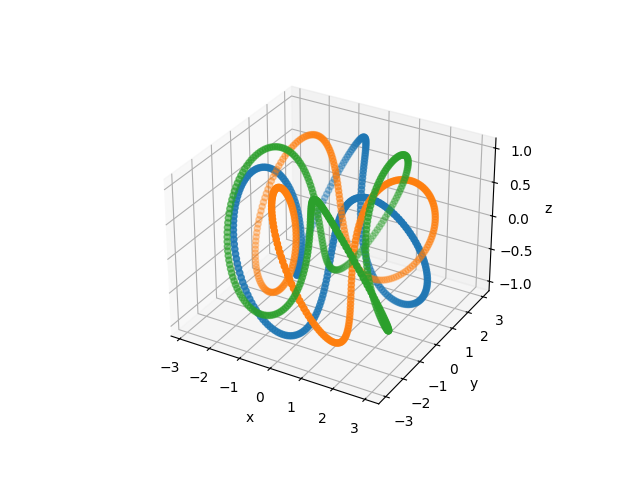

In [73]:
collections = []
for i in range(n): #We retrieve the points in "features" component by component
    x_ = [torusLinkFeatures[k][0] for k in range(i*int(N/n), (i+1)*int(N/n))]
    y_ = [torusLinkFeatures[k][1] for k in range(i*int(N/n), (i+1)*int(N/n))]
    z_ = [torusLinkFeatures[k][2] for k in range(i*int(N/n), (i+1)*int(N/n))]
    collections.append([x_, y_, z_])

ax = threeDimPlot(collections)
plt.show()

In [74]:
plt.close() #Frees the memory occupied by the figure. 

## Training neural networks

We use `torch` to train neural networks: below are classical `torch` imports. The first cell imports `nn`, which contains the `Module` class from which our model will inherit. The third cell import wrapper and helper functions from the `ISLP` package. These are not part of `torch`, but are provided by the authors of the ISLP book (https://www.statlearning.com/) to ease the syntax of certain `torch` code snippets in simple cases. 

In [139]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchinfo import summary

In [140]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [141]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

### Arranging the data into a `DataModule`

We transform our data into `tensors`, the standard datatype accessible to `torch`. Note that `torch` typically works with 32-bit (= single precision) floating point numbers. We therefore convert the $x$, $y$ and $z$ coordinates of our data to `np.float32` before forming the tensor. On the other hand, the reponse --the index of the component a point lies in-- is an integer, which we are required to convert into a 64-bit integer to use `torch`´s cross-entropy loss function. The features and responses tensors are then arranged into a `Dataset` using `TensorDataset()`. Because the general training setup in `pytorch_lightning` involves training, validation and test data, we carry this task out three times. Our data is simulated, so this is virtually free. 

In [156]:
p, q = 3, 9
n = int(np.gcd(p, q))
N = 10000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
M = n*int(N/(10*n)) #A smaller size for validation and test

features_tmp, responses_tmp = simulateData(p, q, N)
torusLinkFeatures_train_t = torch.tensor(features_tmp.astype(np.float32))
torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_train = TensorDataset(torusLinkFeatures_train_t, torusLinkResponses_train_t)

features_tmp, responses_tmp = simulateData(p, q, M)
torusLinkFeatures_val_t = torch.tensor(features_tmp.astype(np.float32))
torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_val = TensorDataset(torusLinkFeatures_val_t, torusLinkResponses_val_t)

features_tmp, responses_tmp = simulateData(p, q, M)
torusLinkFeatures_test_t = torch.tensor(features_tmp.astype(np.float32))
torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_test = TensorDataset(torusLinkFeatures_test_t, torusLinkResponses_test_t)

Each dataset is passed to a `DataLoader()`, which ultimately passes data into the network. The helper function `SimpleDataModule()` from `ISLP` makes this easy. One of its arguments is `num_workers`, which indicates how many processes we will use for loading the data. The `torch` package will inspect the process running and determine a maximum number of workers. (This depends on the computing hardware and the number of cores available.) The `ISLP` package contains function `rec_num_workers()` to compute this. 

In [157]:
max_num_workers = rec_num_workers()
max_num_workers

8

Each of the training, validation and test datasets are passed to different data loaders. This is made hidden here by the `SimpleDataModule` function. During each epoch, a training step is ran to train the model and a validation step to track the error. The test data is typically
used at the end of training to evaluate the model. 

In [159]:
torusLink_dm = SimpleDataModule(torusLinkData_train,
                                  torusLinkData_test,
                                  batch_size = 32,
                                  num_workers = max_num_workers,
                                  validation = torusLinkData_val)

### Specifying the network

We move on to the neural network itself. We define a sub-class `TorusLinkModel` of `torch`'s generic `nn.Module` and specify the architecture of the neural network we want to use. In our situation it is fairly straitghtforward, consisting of linear and ReLU activation layers only. The `layer_sizes` array in the `__init__` method summaries the whole shape of the network: its size indicates the desired number of combined linear and activation layers, and the $i$-th value indicates the size of the $i$-th layer. 

In [145]:
class BuildingBlock(nn.Module):
    
    def __init__(self, in_size, out_size): 
        super(BuildingBlock, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_size, out_size))

    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [160]:
class TorusLinkModel(nn.Module):
    
    def __init__(self, layer_sizes, input_size, output_size): 
        super(TorusLinkModel, self).__init__()
        self.flatten = nn.Flatten()
        self.first_maps = nn.Sequential(nn.Linear(input_size, layer_sizes[0]))
        self.middle_maps = nn.Sequential(*[BuildingBlock(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)])
        self.last_maps = nn.Sequential(nn.ReLU(), nn.Linear(layer_sizes[-1], output_size))

    def forward(self, x):
        x = self.flatten(x)
        x = self.first_maps(x)
        x = self.middle_maps(x)
        return self.last_maps(x)

The package `torchinfo` provides a `summary()` function that neatly summarizes this information. We specify the size of the input and see the size of each tensor as it passes through layers of the network. 

In [193]:
layer_sizes = [6, 6, 6, 6]
torusLink_model = TorusLinkModel(layer_sizes, 3, n)

In [194]:
summary(torusLink_model, 
        input_size = [N, 3],
        col_names = ['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorusLinkModel                           [9999, 3]                 [9999, 3]                 --
├─Flatten: 1-1                           [9999, 3]                 [9999, 3]                 --
├─Sequential: 1-2                        [9999, 3]                 [9999, 6]                 --
│    └─Linear: 2-1                       [9999, 3]                 [9999, 6]                 24
├─Sequential: 1-3                        [9999, 6]                 [9999, 6]                 --
│    └─BuildingBlock: 2-2                [9999, 6]                 [9999, 6]                 --
│    │    └─Flatten: 3-1                 [9999, 6]                 [9999, 6]                 --
│    │    └─Sequential: 3-2              [9999, 6]                 [9999, 6]                 42
│    └─BuildingBlock: 2-3                [9999, 6]                 [9999, 6]                 --
│    │    └─Flatten: 3-3           

We summon an instance of TorusLinkModel and build a `Module` out of it. We again use a helper function from `ISLP`: `SimpleModule()`. By using the `SimpleModule.classification()` method,  we indicate that we will the cross-entropy loss function (instead of, typically, mean squared error for a regression problem). We supply it with the number of classes in the problem. If we were to specify a non-default learning rate (the default one is $0.01$ by the way), or other specific instructions for the upcoming stochastic gradient descent, this would be the place to do it (look into "`torch optimizers`"). 

In [195]:
torusLink_module = SimpleModule.classification(torusLink_model, num_classes = n)

A quick calculation finds back the number of parameters displayed in the summary above. 

In [197]:
def num_parameters(layer_sizes, input_size, output_size):
    num_param = (input_size + 1)*layer_sizes[0]
    for i in range(len(layer_sizes) - 1):
        num_param += (layer_sizes[i] + 1)*layer_sizes[i + 1]
    num_param += (layer_sizes[-1] + 1)*output_size
    return num_param
num_parameters(layer_sizes, 3, n)

171

### Setting a logger

We log our results via `CSVLogger()`, which stores the results in a CSV file within a directory `logs/torusLink`. After the fitting is complete, this allows us to easily load the results as a `pd.DataFrame()` and visualize them. 

In [150]:
torusLink_logger = CSVLogger('logs', name = 'torusLink')

### Training the model

Finally we are ready to train our model and log the results. We use the `Trainer()` object from `pytorch_lightning` to do this work. The argument `datamodule=hit_dm` tells the trainer how training/validation/test logs are produced, while the first argument `hit_module` specifies the network architecture as well as the training/validation/test steps. The `callbacks` argument allows for several tasks to be carried out at various points while training a model. Here our `ErrorTracker()` callback will enable us to compute validation error while training and, finally, the test error. We now fit the model for 50 epochs.

In [151]:
torusLink_trainer = Trainer(deterministic = False,
                      max_epochs = 30,
                      log_every_n_steps = 5,
                      logger = torusLink_logger,
                      callbacks = [ErrorTracker()])
torusLink_trainer.fit(torusLink_module, datamodule = torusLink_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 171    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
171       Trainable params
0         Non-trainable params
171       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


At each step of stochastic gradient descent, the algorithm randomly selects 32 training observations for the computation of the gradient. An epoch amounts to the number of stochastic gradient descent steps required to process $N$ observations. Since the training set has $N = 10000$, and we specified a `batch_size` of $32$ in the construction of  `torusLink_dm`, an epoch is $10000/32 = 312.5$ stochastic gradient descent steps. 

### Testing the model and plotting results

In [152]:
torusLink_trainer.test(torusLink_module, datamodule = torusLink_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9599599838256836
        test_loss           0.10553283989429474
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10553283989429474, 'test_accuracy': 0.9599599838256836}]

The results of the fit have been logged into a CSV file. We can find the
results specific to this run in the `experiment.metrics_file_path`
attribute of our logger. Note that each time the model is fit, the logger will output
results into a new subdirectory of our directory `logs/hitters`.

We now create a plot of the MAE (mean absolute error) as a function of
the number of epochs.
First we retrieve the logged summaries.

In [153]:
def summary_plot(results,
                 ax,
                 col,
                 y_label, 
                 valid_legend = 'Validation',
                 training_legend = 'Training'):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],
                       [training_legend, valid_legend]):
        results.plot(x = 'epoch',
                     y = column,
                     label = label,
                     marker = 'o',
                     color = color,
                     ax = ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(y_label)
    return ax

<Axes: xlabel='Epoch', ylabel='Accuracy'>

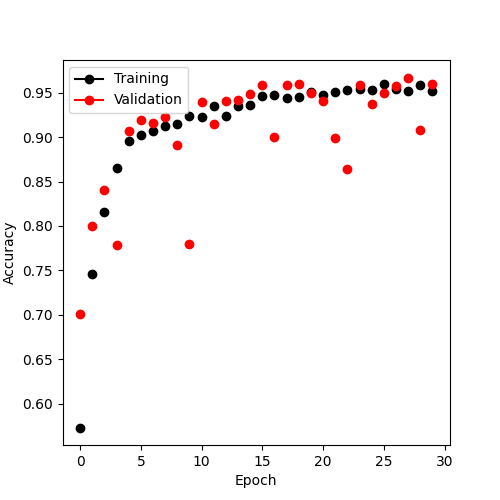

In [154]:
torusLink_results = pd.read_csv(torusLink_logger.experiment.metrics_file_path)
fig, ax = pyplot.subplots(1, 1, figsize=(5, 5))
summary_plot(torusLink_results, ax, 'accuracy', 'Accuracy')

### Cleanup 

In [155]:
del(torusLink_model, torusLink_dm, torusLink_module,
    torusLink_logger,torusLink_trainer,
    features_tmp, responses_tmp)
plt.close()

# WORK IN PROGRESS. TO DO: LET p, q, THE SIZE AND NUMBER OF LAYERS IN THE NETWORK VARY. 